<a href="https://colab.research.google.com/github/gondore/nsdc-crafter/blob/main/dqn_implementation_2_20_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gymnasium crafter stable_baselines3 shimmy[gym-v26]

# **Quick Start**
Replace '/content/sample_data/new_mount_2' with a new empty folder path in google colab. Replace other file paths with the same path you used appropriately.

- After training, you will get a collection of short videos inside the file path – these are videos of each episode. W
- We can use the dedicated video concatenation function to combine all the videos together as final_training_video.mp4.
- data can be found through the stats.jsonl file generated in the file path after training

In [ ]:
import gymnasium as gym
import crafter


env = crafter.Env()
env = crafter.Recorder(
  env, '/content/sample_data/new_mount_2',
  save_stats=True,
  save_video=True,
  save_episode=False,
)
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import numpy as np
from skimage.color import rgb2gray
from skimage import transform
import matplotlib.pyplot as plt
from collections import deque
import random

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("The action size is : ", env.action_space.n)
# one hot encode actions
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())


The action size is :  17


**Preprocessing observationspace**

We could experiment with performance by playing with:

- grayscale frames
- normalizing pixel values
- resize preprocessed frame/ cut off the health bar and inventory maybe?


In [ ]:
def preprocess_frame(frame):
    # Greyscale frame
    gray = rgb2gray(frame)

    # Normalize Pixel Values
    normalized_frame = frame/255.0

    # Resize
    preprocessed_frame = transform.resize(normalized_frame, [110,84])

    return preprocessed_frame # 110x84x1 frame

In [ ]:
# try out using tensorboard maybe?
#writer = tf.summary.FileWriter("/tensorboard/dqn/1")

## Losses
#tf.summary.scalar("Loss", DQNetwork.loss)

#write_op = tf.summary.merge_all()

In [ ]:
pip install gymnasium torch numpy matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt



class ConvDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvDQN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4),  # input channels = 3 for RGB images
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # Change image format from HWC to CHW expected by PyTorch
        conv_out = self.conv_layers(x).reshape(x.size(0), -1)  # Flatten the output for the FC layers
        return self.fc_layers(conv_out)



In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.buffer)


In [ ]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, replay_buffer):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.model = ConvDQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters())
        self.criterion = nn.MSELoss()
        self.epsilon = 0.99
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.gamma = 0.99

    def act(self, state):
        if random.random() > self.epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state)
            action = q_values.max(1)[1].item()
        else:
            action = random.randrange(self.action_dim)
        return action

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.criterion(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [ ]:
state_dim = np.prod(env.observation_space.shape)  # This ensures a flat vector input size is correctly identified
action_dim = env.action_space.n

#state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(state_dim, action_dim, replay_buffer)

def train_dqn(episodes):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        while True:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            agent.train(32)
            if done:
                break
        rewards.append(episode_reward)
        print(f'Episode: {episode}, Reward: {episode_reward}')
        agent.epsilon = max(agent.epsilon_min, agent.epsilon_decay * agent.epsilon)  # Decay epsilon
    return rewards

episodes = 10
rewards = train_dqn(episodes)


Episode: 0, Reward: 1.1
Episode: 1, Reward: -0.8999999999999999
Episode: 2, Reward: 2.099999999999999
Episode: 3, Reward: 2.099999999999999
Episode: 4, Reward: 3.099999999999999
Episode: 5, Reward: 3.099999999999999
Episode: 6, Reward: 4.1
Episode: 7, Reward: 3.099999999999999
Episode: 8, Reward: 4.099999999999999
Episode: 9, Reward: 4.099999999999999


In [ ]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
import os

video_directory = '/content/sample_data/new_mount_2'  # Ensure this is your correct directory
video_files = [f for f in os.listdir(video_directory) if f.endswith('.mp4')]

# Debug: Print out video files found (or not found)
print("Found video files:", video_files)

if not video_files:
    raise ValueError("No video files found in the directory.")

video_files.sort()  # Make sure this sorts the files in the order you expect

# Full paths to video files
video_paths = [os.path.join(video_directory, f) for f in video_files]

# Load video clips
clips = [VideoFileClip(f) for f in video_paths]

# Concatenate the video clips
final_clip = concatenate_videoclips(clips)

# Save the concatenated video
final_video_path = os.path.join(video_directory, 'final_training_video.mp4')
final_clip.write_videofile(final_video_path)


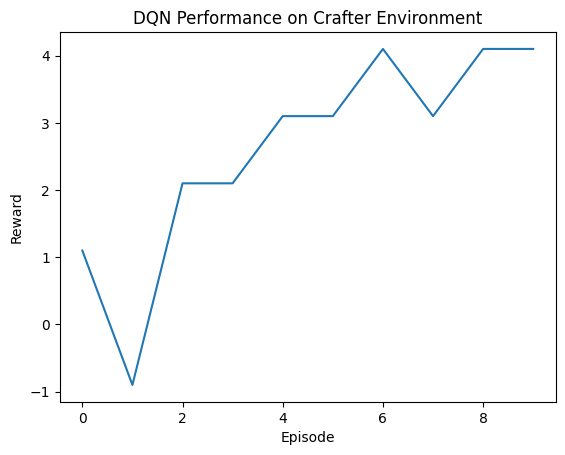

In [31]:
plt.plot(range(episodes), rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Performance on Crafter Environment')
plt.show()

# **analysis starter**
- what actions were taken the most?
- how does DQN agent’s performance change over time during training? is there a specific time step range where it spikes?
    
    → we can plot rewards over time, which can help us identify if and when the agent performance plateaus and in response change learning rate, epxloration strategy, network architecture
    
- how does DQN performance change due to learning rate, discount factor, and exploration decay changes
    
    → we can do a grid search or random search over the 3 hyperparameter values to see how the different ranges affect performance
    
- what is the agent’s major hump (the achievement that it gets stuck at)?

→ figure out how to analyze the stats.json file and see the achievement max

In [35]:
import json
import pandas as pd

stats_file_path = '/content/sample_data/new_mount_2/stats.jsonl'

stats_data = []

with open(stats_file_path, 'r') as file:
    for line in file:
        stats_data.append(json.loads(line))


# create a DataFrame where each key becomes a column
df_stats = pd.DataFrame(stats_data)



In [ ]:
# Display the first few rows of the DataFrame
print(df_stats.head())

# Summary statistics
print(df_stats.describe())


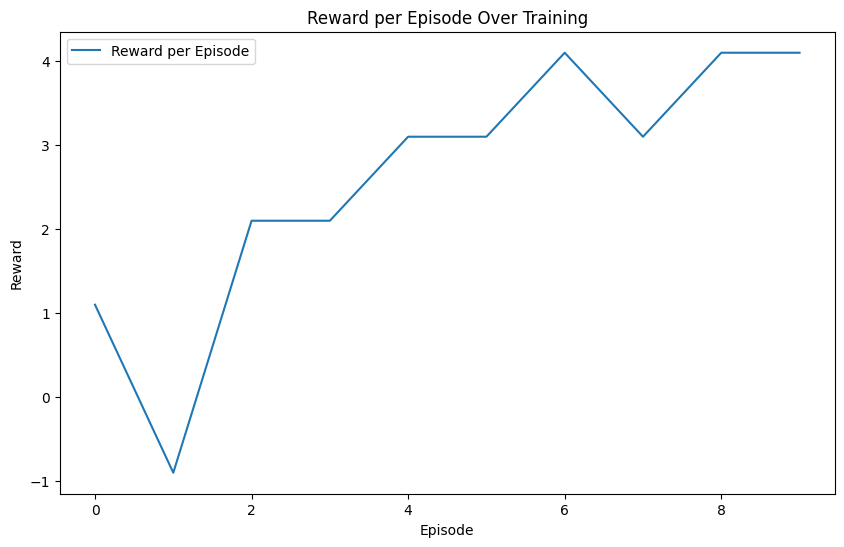

In [39]:
import matplotlib.pyplot as plt

# Assuming 'reward' is the name of the column storing the reward per episode
plt.figure(figsize=(10, 6))
plt.plot(df_stats.index, df_stats['reward'], label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode Over Training')
plt.legend()
plt.show()
